**Phish Reddit: r/phish sentiment analysis with:**

K-Means and Hierarchical Clustering

Collect data from a social media source of choosing (at least 1000 posts). 
Gathered Reddit data using the programming library praw.<br>

- Use both K-Means and HCA to cluster the collected data
- Draw a dendrogram
- Identify number of optimum clusters, and justify how do you pick number of clusters
- List the top 10 most frequent words
- Visualize using wordclouds
- Summarize your findings

Looking into data from r/phish can be informative in several ways and provide possible insights. Firstly, analyzing the data from a this subreddit can give us an idea about the users of that subreddit, their interests, and what they are discussing. This can help us understand the current trends, preferences, and opinions of the community.<br> 

Secondly, by clustering the collected data using techniques such as K-Means and HCA, we can identify patterns and group similar data points together. This can help us better understand the topics that are being discussed and the different perspectives of the users. 

Thirdly, drawing a dendrogram helps us visualize the clusters and their relationships, making it easier to interpret the data and identify any outliers. 

Identifying the number of optimum clusters and justifying how we pick the number of clusters can help us avoid overfitting or underfitting the data and ensure that our analysis is accurate and meaningful. 

Lastly, listing the top 10 most frequent words and visualizing them using word clouds can provide insights into the most popular topics and the language used by the users. 

Overall, analyzing data from a random subreddit can provide valuable insights into the interests and opinions of a particular community and help us understand the current trends and popular topics.

**Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import praw


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings("ignore")

**Collect Data:** I am using data scraped from the r/phish subreddit, from reddit.com

In [2]:
reddit = praw.Reddit(client_id='WdfbS3zq_RlVZMLYItS2DQ', client_secret='hipY0ks7e-P6pdWlQhrfytUqKyAFYg', user_agent='MSDS680 Kmean - HCA')
  

**Preprocess Data:** Before clustering, the data needs to be preprocessed. To process the text data for clustering algorithms like k-means and hierarchical cluster analysis (HCA), converting the text into a numerical representation is necessary. A common approach is to use the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. 

In [3]:
from praw.models import MoreComments
reddit = praw.Reddit(user_agent="Comment Extraction (by /u/erinkane)",
                     client_id="WdfbS3zq_RlVZMLYItS2DQ", client_secret="hipY0ks7e-P6pdWlQhrfytUqKyAFYg")
subreddit = reddit.subreddit('phish')

# Collect posts
posts = []
for post in subreddit.hot(limit=1000):  # Adjust the limit if needed
    posts.append([post.title, post.selftext])

df = pd.DataFrame(posts, columns=['title', 'body'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   995 non-null    object
 1   body    995 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


In [5]:
df

,title,body
0,Mondegreen,Fest announcement\nhttps://mondegreen.phish.com/
1,Summer tour announcement,
2,What is your MOST listened-to jam ever?,For me it’s the Cypress Sand.
3,ADA tickets on StubHub,Dear person or persons that bought ADA accessi...
4,Finally got this one framed a hung up!!,
...,...,...
990,"Was listening to Phish and Meatstick played, I...",Is it possible to listen to Meatstick and not ...
991,Jooge’s matrix recordings,"Hi, I am trying to get a copy of Jooge’s vario..."
992,Could The Sphere be an annual event?,My apologies if this question has already been...
993,The “charge!” signal,Maybe I’m crazy but I swear I remember this an...


In [6]:
# Removing Stopwords
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords from NLTK
nltk.download('stopwords')

def remove_stopwords_punctuation(text):
    # Ensure text is a string
    text = str(text)
    
    # Tokenize the text into words
    words = text.split()
 
    # Get a set of English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove punctuation from the list of words
    cleaned_words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
    
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

df['cleaned_text'] = df['title'].apply(remove_stopwords_punctuation)
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ebdai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,body,cleaned_text
0,Mondegreen,Fest announcement\nhttps://mondegreen.phish.com/,Mondegreen
1,Summer tour announcement,,Summer tour announcement
2,What is your MOST listened-to jam ever?,For me it’s the Cypress Sand.,jam
3,ADA tickets on StubHub,Dear person or persons that bought ADA accessi...,ADA tickets StubHub
4,Finally got this one framed a hung up!!,,Finally got one framed hung
...,...,...,...
990,"Was listening to Phish and Meatstick played, I...",Is it possible to listen to Meatstick and not ...,listening Phish Meatstick get
991,Jooge’s matrix recordings,"Hi, I am trying to get a copy of Jooge’s vario...",matrix recordings
992,Could The Sphere be an annual event?,My apologies if this question has already been...,Could Sphere annual
993,The “charge!” signal,Maybe I’m crazy but I swear I remember this an...,signal


In [7]:
missing_data = df.isnull().sum()
print(missing_data)

title           0
body            0
cleaned_text    0
dtype: int64


**K-Means Clustering**<br>

K-means clustering is a type of unsupervised learning algorithm used in data mining and machine learning. It aims to partition a given dataset into K clusters, where each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. The "K" in K-means clustering refers to the number of clusters that the algorithm will create. It starts by selecting K random points as the centroids of the clusters, and then assigns each point to the nearest centroid. The centroids are then updated by taking the mean of all the points assigned to it, and the process repeats until the centroids no longer move or a maximum number of iterations is reached. The resulting clusters can be visualized to reveal patterns in the data.
Gupta, K. (2021, January)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Example with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])

# K-Means
kmeans = KMeans(n_clusters=5)  # Start with an arbitrary number of clusters
kmeans.fit(X)

# Assign the cluster labels to your dataframe
df['cluster'] = kmeans.labels_ 

TF-IDF helps in representing the text data in a numerical format that is suitable for machine learning algorithms. Here's why it's important:

Term Frequency (TF): It measures the frequency of a term (word) within a document. It helps to highlight the importance of words in individual documents.

Inverse Document Frequency (IDF): It measures how important a term is across all documents in the dataset. It helps in giving more weight to rare words and less weight to common words.

By combining TF and IDF, the TF-IDF matrix assigns weights to each word in the text data, reflecting both its local importance within a document and its global importance across the entire dataset. This way, the matrix captures the essence of the text data and helps in clustering similar documents together based on the content.

https://scikit-learn.org/stable/search.html?q=TF+-+IDF

code citation: https://towardsdatascience.com/aggregation-of-reddit-comments-using-a-scikit-learn-k-means-clustering-algorithm-b6fa6d451e19

*Visualizing the K-Means Clusters*

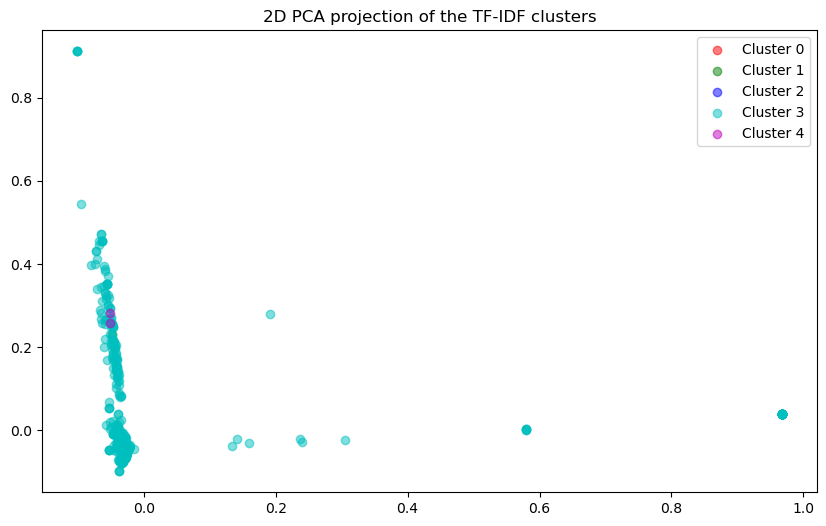

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray()) 

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  

for i, color in enumerate(colors[:len(set(kmeans.labels_))]):
    plt.scatter(reduced_features[kmeans.labels_ == i, 0], reduced_features[kmeans.labels_ == i, 1], 
                color=color, label=f'Cluster {i}', alpha=0.5)

plt.title('2D PCA projection of the TF-IDF clusters')
plt.legend()
plt.show()

There's a lot of data smushed together in one very localized area, interesting, while there are some scattered to the furthest positive on both x and y axises. 

**Hierarchical Clustering and Dendrogram**<br>

Hierarchical clustering is a method of clustering analysis that aims to build a hierarchy of clusters. In this technique, the data is grouped into a tree-like structure, known as a dendrogram. The dendrogram is a visual representation of the clustering process, where each branch represents a cluster and the height of the branch represents the distance between the clusters. 

The hierarchical clustering can be of two types: Agglomerative and Divisive. Agglomerative hierarchical clustering starts with each observation as a separate cluster and then merges them into larger clusters, while divisive hierarchical clustering starts with all the observations in a single cluster and then divides them into smaller clusters.

Dendrogram, on the other hand, is a graph that shows the hierarchical relationship between the clusters. It is a diagrammatic representation of the results of hierarchical clustering. In a dendrogram, the data is represented by a set of points called leaves, which are joined together by lines called branches. The length of the branches represents the distance between the clusters. The higher the height of the branch, the less similar the clusters are. 

https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Hierarchical Clustering
Z = linkage(X.toarray(), method='ward')

Z

array([[0.00000000e+00, 1.60000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.00000000e+00, 1.96000000e+02, 0.00000000e+00, 2.00000000e+00],
       [5.90000000e+01, 7.10000000e+01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.97800000e+03, 1.98500000e+03, 3.73381687e+00, 9.45000000e+02],
       [1.91200000e+03, 1.98600000e+03, 4.15789163e+00, 9.63000000e+02],
       [1.95500000e+03, 1.98700000e+03, 7.38591789e+00, 9.95000000e+02]])

**Dendrogram:**

Since I've performed HCA and have the linkage matrix, I can draw a dendrogram to decide on the number of clusters

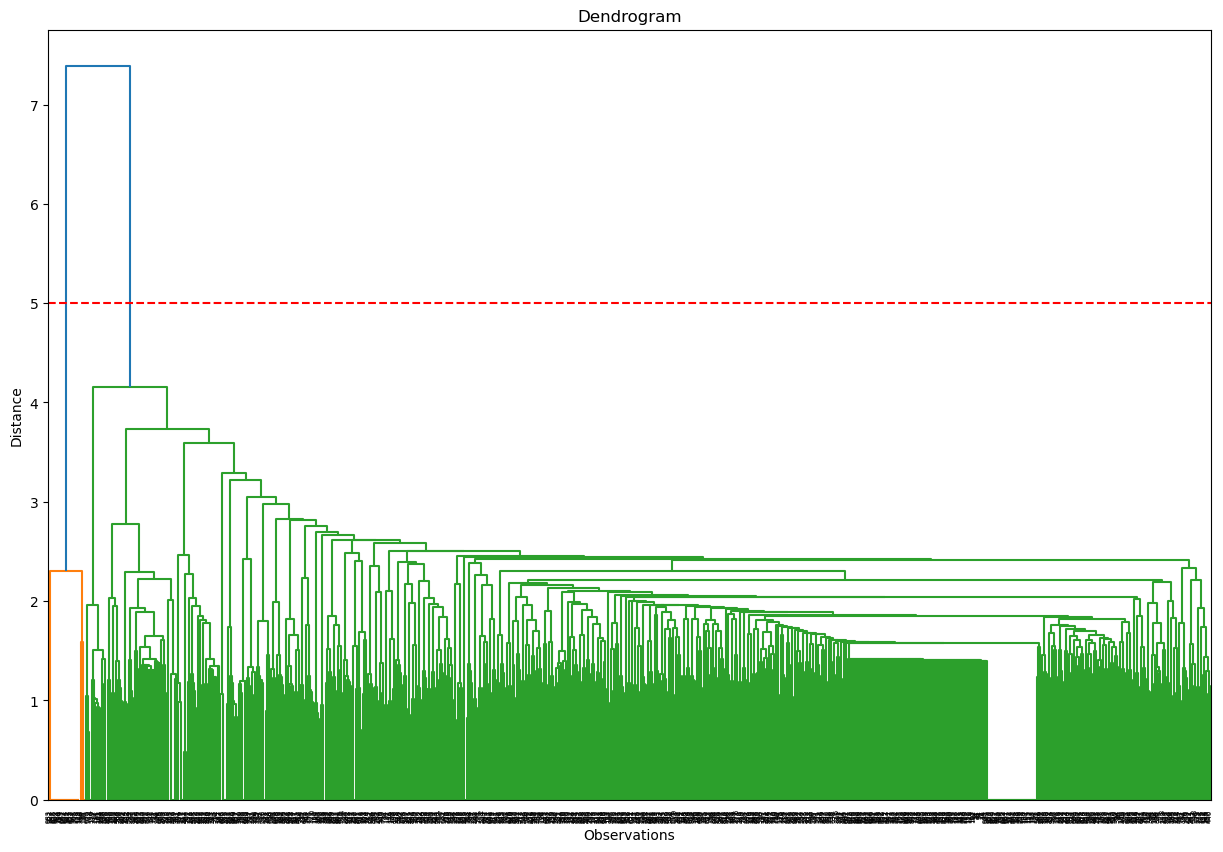

In [11]:
plt.figure(figsize=(15, 10))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.axhline(y=5, color='r', linestyle='--')
plt.show()

This Dendrogram is wild lots condensed at the bottom. With the reference line cuts at 5, there are two clusters identified. However, we can see that there are many more below the reference line, and possibly a big chuck to the bottom right of the graph, it shows a large gap between many of the clusters and the beginning/end of another set of clusters. I'll try my luck with the Silhouette score.

**Optimum Number of Clusters:**

To optimize clustering, I'll take a look at the Elbow Method for K-Means, the Dendrogram for Hierarchical Clustering Analysis (HCA), and the Silhouette Score, it's essential to understand what each method offers:<br>

* **Elbow Method (K-Means):** Identifies the optimal number of clusters by finding the point where the decrease in the within-cluster sum of squares (WCSS) begins to slow down ("elbows").<br>

* **Dendrogram (HCA):** Provides a visual way to inspect the formation of clusters based on distance. It can help identify a suitable number of clusters by looking for the longest vertical distance that doesn’t intersect any clusters. <br>

* **Silhouette Score:** Measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

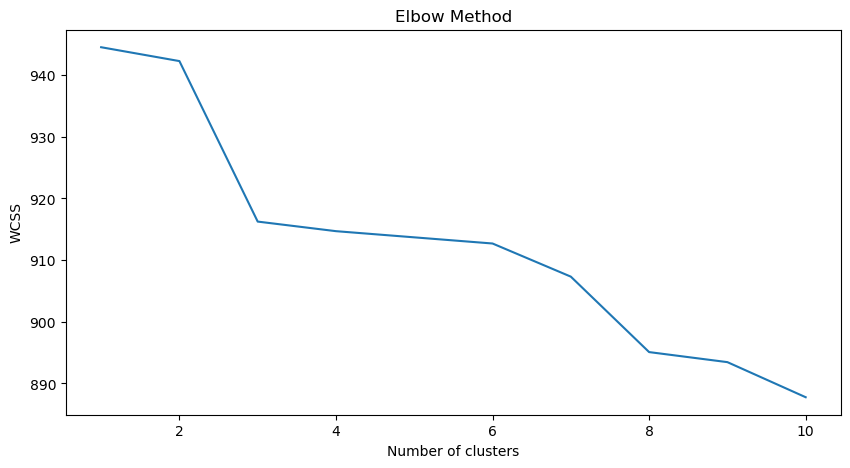

KMeans(n_clusters=10, random_state=42)

In [12]:
wcss = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

kmeans

#https://scikit-learn.org/1.4/modules/generated/sklearn.cluster.KMeans.html

The graph looks kinda like a "Z", it suggests a scenario where there isn't a clear and distinct "elbow" point. Typically, the Elbow Method graph is expected to show a sharp bend, resembling an elbow, which indicates the optimal number of clusters. This bend signifies a point beyond which increasing the number of clusters does not result in a significant decrease in the within-cluster sum of squares (WCSS). However, a "Z" shaped graph suggests a few different possibilities:<br>

* Linear Decrease: If the graph sharply decreases and then levels off with no distinct elbow, it may indicate that additional clusters beyond a certain point do not meaningfully improve the model. The point where the graph starts to level off could be considered for the number of clusters, but it's less definitive than a clear elbow.

* Abrupt Change: A graph that resembles a "Z" might also show an abrupt change in slope at two points, suggesting there are two potential points to consider for the number of clusters. This could mean that there are two levels of granularity at which the data could be meaningfully clustered, and your choice might depend on the context of your analysis or specific requirements.

* Lack of Clear Optimal Number of Clusters: Sometimes, a "Z" shaped or a linear graph indicates that the data does not naturally cluster into a small number of distinct groups, or the chosen features and distance metrics may not be capturing the underlying structure of the data well.<br>

I'll continue on with the Dendrogram and Silhouette Score to see if there's an *optimal* way to see the data and where the sweet spot number of clusters might be. <br>

https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

**Silhouette Score**<br>
The Silhouette Score can be used with any clustering method, including K-Means or HCA, to evaluate the quality of clustering.

In [13]:
# To compute the silhouette score
labels = kmeans.labels_

score = silhouette_score(X, labels, metric='euclidean')
print('Silhouette Score:', score)

Silhouette Score: 0.04283275301804779


A Silhouette Score of 0.0428 suggests that the clustering result is weak and indicates that the clusters are not well-defined or distinct from each other. Here’s a breakdown of what the Silhouette Score typically indicates: The Silhouette Score ranges from -1 to 1, where:

* A score close to 1 means that the clusters are well separated and cohesive, indicating that each data point is well matched to its own cluster and poorly matched to neighboring clusters. This is an ideal scenario.

* A score of 0 suggests that the clusters are overlapping and there is significant inter-cluster similarity. This indicates that the boundary between clusters is not well defined, and data points on the edge of a cluster could also belong (almost equally well) to another cluster.

* A score close to -1 means that clusters are poorly separated, and data points have been assigned to the wrong clusters.<br>

**Identifying Top 10 Most Frequent Words in the r/phish subreddit**

In [14]:
from collections import Counter

words = " ".join(df['cleaned_text']).split()
most_common_words = Counter(words).most_common(11)
print(most_common_words)

[('Phish', 108), ('Mexico', 46), ('Today', 31), ('Phishstory', 30), ('February', 30), ('Trey', 28), ('Best', 22), ('like', 22), ('Sphere', 21), ('phish', 20), ('Anyone', 19)]


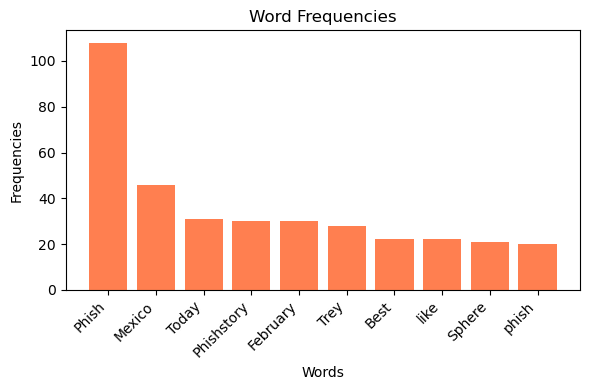

In [15]:
# Plotting the most common words in the r/phish subreddit
data = [('Phish', 108), ('Mexico', 46), ('Today', 31), ('Phishstory', 30), ('February', 30), ('Trey', 28), ('Best', 22), ('like', 22), ('Sphere', 21), ('phish', 20)]

# Unpack the list of tuples into two lists
words, frequencies = zip(*data)

plt.figure(figsize=(6,4))

# Create a bar chart: plt.bar(x-coordinates, heights)
plt.bar(words, frequencies, color='coral')

# Add title and labels
plt.title('Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequencies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")  # Rotate labels and align right for better spacing

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Looks like a lot of people are excited for the new shows coming up for Phish playing in Mexico and at the Sphere in Vegas. <br>

**WordCloud:**<br>
Wordclouds are a fun way to represent sentiment analysis and can be pretty interesting to look at, but from an analytical perspective their value is debatable. 

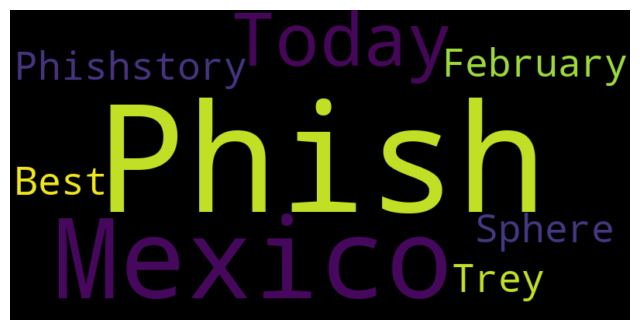

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black', width=800, height=400).generate(" ".join(words))

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**Findings:**<br>

In analyzing the r/phish subreddit, I employed K-means clustering, visualized the results using the Elbow method and Hierarchical Cluster Analysis (HCA) accessing dendrograms to visualize, and evaluated cluster quality with the silhouette score, identified the ten top words used in the subreddit, and made a fun little wordcloud. <br>

*K-Means Clustering:* I performed K-means clustering on the dataset, generating a variety of clusters. The K-means output array hints at the clustering dimensions and characteristics, with values suggesting the formation of distinct groups based on certain features.<br>

*Elbow Method Visualization:* Utilizing the Elbow method allowed us to estimate the optimal number of clusters. This method helps in identifying a point after which the within-cluster sum of squares (WCSS) does not decrease significantly with each additional cluster, indicating a diminishing return on the number of clusters.<br>

*Hierarchical Cluster Analysis (HCA):* Further analysis with HCA revealed a complex cluster structure, suggesting a detailed subdivision within the data. HCA provides a visual representation of data segmentation, allowing us to observe the hierarchical relationship between clusters. This was visualized with<br>

*Silhouette Score:* The silhouette score obtained was 0.04283275301804779, indicating a weak structure where clusters are not well-defined and possibly overlapping. This low score suggests that the data might not naturally segment into clearly distinct clusters, or the chosen parameters for clustering did not capture the inherent groupings effectively.<br>

*Top Words Identification:* Analysis of the text content led to identifying the ten most frequent words: 'Phish', 'Mexico', 'Today', 'Phishstory', 'February', 'Trey', 'Best', 'like', 'Sphere', and 'Anyone', with their respective frequencies. This highlights the most discussed topics or terms within the subreddit, pointing towards the interests and focuses of its community.<br>

Conclusion: The clustering analysis of the r/phish subreddit indicates a complex and nuanced community structure, with a low silhouette score suggesting challenges in defining clear, distinct clusters through the methods applied. The identification of top words provides insight into prevalent themes and interests among the subreddit's members, emphasizing topics like events, locations, and key figures related to the Phish band. Further refinement of clustering parameters or exploration of different clustering techniques might yield clearer insights into the community's structure.<br>

**References:**<br>

Gupta, K. (2021, January). In-depth intuition of K-means clustering algorithm in machine learning. Analytics Vidhya. Retrieved from https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

Lloyd, S. P. (1982). Least squares quantization in PCM. IEEE Transactions on Information Theory, 28(2), 129-137. doi:10.1109/TIT.1982.1056489

Patel, D. (2024). Aggregation of Reddit comments using a scikit-learn K-means clustering algorithm. Towards Data Science. Retrieved from https://towardsdatascience.com/aggregation-of-reddit-comments-using-a-scikit-learn-k-means-clustering-algorithm-b6fa6d451e19

Prasad, P. (2021, May). Hierarchical Clustering Eplained. Towards Data Science. Retrieved from https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8

scikit-learn developers. (2024). sklearn.metrics.silhouette_score. scikit-learn: machine learning in Python. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

scikit-learn developers. (2024). sklearn.datasets.make_blobs. scikit-learn: machine learning in Python. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

scikit-learn developers. (2024). Search results for "TF - IDF". scikit-learn: machine learning in Python. Retrieved from https://scikit-learn.org/stable/search.html?q=TF+-+IDF